# Final Project

### 獲取歷史資料

In [45]:
from finlab.data import Data

data = Data()

#這個final project非常特別，也是外面的課程不會教你的一些方法，都會納入其中！
#首先，我們跟之前的每個單元一樣，使用data這個interface來抓取訓練資料

# 獲取當月營收、收盤價
rev      = data.get("當月營收")
close    = data.get("收盤價")

# 將當月營收改成15號才出來
rev.index = rev.index.shift(5, 'd')

#我們會設計一個模型，它只需要收盤價跟月營收，就可以判斷股價的漲跌！
#我們會讓這個模型每個月的15號進行股票的調整，並且每次持有30檔以內的股票，看看效果如何～

### 計算features

In [46]:
# 有了歷史資料，也就是「月營收」跟「收盤價」後，我們就可以來設計feature了！
# 我們首先要設計一些製作feature的function，方便我們重複使用
# 首先我們設計第四個單元中，學過的bias，

# 再來，我們來使用一種加速度指標！這種加速度指標的公式和原理，我們都曾經放在finlab的部落格上，假如有興趣可以去研究一下
# 這邊我們就不額外節外生枝，方便大家有一個整體的概念
# 最後，是小資族選股策略中的rsv指標，這個指標可以幫我們找出股票近期的相對位置，相較於歷史位置是高還是低
# 另外呢，除了股價的指標，我們也可以使用mom
# 也就是，當前月營收除以前一個月營收，這個指標，將月營收的狀況當成features


import numpy as np

avg = lambda n: close / close.rolling(n, min_periods=int(n/2)).mean()
acc = lambda n: close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    return (close - l) / (h - l)

mom = rev / rev.shift()

# 最後我們可以將features 結合起來，變成一張很大的table叫做features

features = {
    'mom1': mom,
    'mom2': mom.shift(1),
    'mom3': mom.shift(2),
    'mom4': mom.shift(3),
    'mom5': mom.shift(4),
    'mom6': mom.shift(5),
    'mom7': mom.shift(6),
    'mom8': mom.shift(7),
    'mom9': mom.shift(8),
    
    'avg5': avg(5),
    'avg10': avg(10),
    'avg20': avg(20),
    'avg60': avg(60),
    'avg120': avg(120),
    'avg240': avg(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
    'rsv60': rsv(60),
    'rsv120': rsv(120),
    'rsv240': rsv(240),
} 


### 製作dataset

##### 設定買賣頻率

In [82]:
# 接下來我們要訣定取樣的頻率，
# 我們可以設定每個月買入，這樣的話，我們的取樣頻率就是每個月，我們可以看revenue這個dataframe，
# 它的index剛好就是每個月的日期，所以我們將它額外存起來，叫做every_month

#every_week = close.index[close.index.weekday == 1]
every_month = rev.index

##### 將dataframe 組裝起來

In [66]:
# 接下來我們就可以將剛剛的features這個dictionary，每個月取樣，並轉換成dataset，
# 首先我們先來看單一個feature要怎麼轉換型態：
# 首先我們可以取bias 20，我們可以看到它是一張dataframe，但是它的頻率是「每天」，所以我們可以先用reindex
# 將每天的頻率變成每個月
# 然後呢，我們也希望這張dataframe進一步轉換成machine learning可以學習的格式，
# 所以使用unstack來將dataframe變成series，之後我們對於每個feature都如此，將每個feature都變成一條series，最後再將所有的series合併起來
# 就可以產生出machine learning讀的懂得dataframe囉！
# 那要怎麼將d所有的feature都做上述的操作呢？我們可以用for迴圈，去將所有的feature都做一次剛剛的動作，
# 這邊的name就是feature名稱，而df就是原feature最原始的dataframe
# 如此一來我們就可以對所有的features都做一樣的操作，並且將一個個結果都存到dataset裡面
# 最後呢，我們再將dataset從dictionary轉換成dataframe就可以完成囉！
# 我們可以額外將feature_names給存起來，這樣之後就可以輕易的增刪feature，而不需要直接改dataframe

import pandas as pd


dataset = {}

for n,s in features.items():
    dataset[n] = s.reindex(every_month, method='ffill').unstack() 

dataset = pd.DataFrame(dataset)

#dates = sorted(list(set(dataset.reset_index()['date'])))
feature_names = dataset.columns


### 新增 label

In [67]:
# 雖然我們有很多的feature了，但是沒有label，所以呢，我們接下來就要製作一些label讓機器學習模型來預測囉！
# 我們可以用finlab.ml裡面已經寫好的function，幫我們快速的來加入label，這個function叫做add_profit_prediction
# 它會將dataset新增一個新的column叫做return，也就是報酬率的意思！

# 在最後的解鎖內容，我們將教大家如何讓神經網路的訓練效果變得更好，
# 以往我們訓練神經網路，都是用來預測報酬率，或是夏普值，
# 但在我們的實驗中，我們發現報酬率非常容易受大盤的影響，
# 也就是當大盤不好的時候，報酬率普遍都不好，當大盤很好的時候，報酬率普遍都很好
# 受到大盤的影響，預測報酬率非常的困難，所以我們可以預測另一種東西，來選出好的股票，也就是「股票的排名」
# 
# 另外，我們也會特別計算股票的排名，rank，假如某檔股票在同個月份中，有最高的報酬率，它的rank會是1，假如報酬率最低
# 則是0，將報酬率從小到大排列，這個就是訓練神經網路非常重要的一個方法，我們不是預測報酬率，
#
# 預測股票的排名會比直接預測股票的漲跌還要有意義，就算大盤大跌，還是可以選出跌幅比較小的股票，大盤漲的時候，也可以
# 選出漲幅比較高的股票，簡而言之，我們選的股票在所有的股票裡面，比較容易抗跌、比較容易上漲，的股票！
# 這也是本門課中，我覺得非常有價值的選股小撇步，讓模型的預測能力可以大躍進。

import finlab.ml as ml

def add_profit_prediction(dataset):
    
    dates = sorted(list(set(dataset.reset_index()['date'])))
    
    adj_open = data.get_adj('開盤價')
    
    tomorrow_adj_open = adj_open.shift(-1)
    tomorrow_adj_open = tomorrow_adj_open.reindex(dates, method='bfill')
    
    
    p = (tomorrow_adj_open.shift(-1) / tomorrow_adj_open)
    dataset['return'] = p.unstack()
    
def add_rank_prediction(dataset):
    
    dates = sorted(list(set(dataset.reset_index()['date'])))
    
    adj_open = data.get_adj('開盤價')
    
    tomorrow_adj_open = adj_open.shift(-1)
    tomorrow_adj_open = tomorrow_adj_open.reindex(dates, method='bfill')
    
    
    p = (tomorrow_adj_open.shift(-1) / tomorrow_adj_open).rank(axis=1, pct=True)
    dataset['rank'] = p.unstack()
    
add_profit_prediction(dataset)
add_rank_prediction(dataset)

In [35]:
#%matplotlib inline
#
#def add_prediction(dataset):
#    
#    dates = sorted(list(set(dataset.reset_index()['date'])))
#    
#    data = Data()
#    adj_open = data.get_adj('開盤價')
#    
#    tomorrow_adj_open = adj_open.shift(-1)
#    tomorrow_adj_open = tomorrow_adj_open.reindex(dates, method='bfill')
#    
#    
#    p = (tomorrow_adj_open.shift(-1) / tomorrow_adj_open)
#    dataset['rank'] = p.rank(axis=1, pct=True).unstack()
#    dataset['rank'] = p.unstack()
#    
#add_prediction(dataset)
#

In [68]:
# 我們剛剛也有說，可以用任意刪減feature_names來決定說我們要用哪些feature
# 用越多的feature不一定越好，例如我們把擲銅板的資料也讓機器學習預測，那反而會造成預測的結果不好喔！
# 所以我們可以移除一些feature，以除的方法如下：
# 我們可以產生一個set這個元素，set這個元素以面就是包含了所有的feature名稱
# 我們可以將不想要的feature名稱給刪除，只要將他們從原本的set中減掉即可
# 最後我們可以將這個feature_names還原成原本的list
# 最後我們可以用sorted讓list的順序比較整齊

feature_names = sorted(list(set(feature_names) - {'acc120', 'acc240', 'prediction'}))
feature_names

['acc10',
 'acc20',
 'acc5',
 'acc60',
 'avg10',
 'avg120',
 'avg20',
 'avg240',
 'avg5',
 'avg60',
 'mom1',
 'mom2',
 'mom3',
 'mom4',
 'mom5',
 'mom6',
 'mom7',
 'mom8',
 'mom9',
 'rsv10',
 'rsv120',
 'rsv20',
 'rsv240',
 'rsv5',
 'rsv60']

In [70]:
# 神經網路最怕的就是outlier，outlier就是那些過大或過小的testcase，會造成神經網路訓練結果不好
# 所以我們可以寫一個drop_extreme_case這個function來將dataset中比較極端的testcase刪除，
# 也就是我們要將一些row刪除，要刪除哪些rows呢？就是當指定的feature_names太大或太小的時候，
# 而什麼時候太大或太小呢？我們可以定義thresh，來將百分之1的極端值給刪除

# 這邊我將function直接貼過來，我們用drop_cases來檢查是否某條row包含極端數值，剛開始這條series的長度會等於dataset的row的數量
# 然後對於每個feature，去檢查是否rows是否為極值，這行有很多的不林運算，其中「|」代表或的意思，
# 也就是只要「|」的左邊跟右邊，任何一個為True，則這個運算就是True
# 而這邊的extreme_cases是向量運算，也就是extreme_cases是一個series，裡面的每個Boolearn都會對應到每條row是否被刪除
# 等式右邊的含意就是：假如extreme_cases是True，或是當feature的數值的大小過小，當feature的數值的大小太大，
# 都會讓extreme_cases變成True
# 最後我們就可以將extreme_cases為True的部分給刪除，也就是保留不是extreme_cases的rows，
# 所以我們需要選取extreme_cases不為True的這些rows

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = drop_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

# 接下來我們就可以來使用這個function，
# 我們希望新的dataset可以變成，將所選的features的前後百分之1％都刪除，有哪些feature呢？
# 有 avg60、120、240、mom1～5，因為這些極值會影響到訓練的結果
    
dataset = drop_extreme_case(dataset, [
    'avg60', 'avg120', 'avg240','mom1', 'mom2', 'mom3', 'mom4', 'mom5'
])

In [71]:
# 最後一步驟，就是將dataset當中有NaN的row給刪除
# 並且將日期設定為index

dataset = dataset.dropna(how='any')
dataset = dataset.reset_index().set_index('date')

# 然後將資料分成訓練用的data跟回測用的data

dataset_train = dataset[:'2015']
dataset_test = dataset['2016':]

### 神經網路模型

In [73]:
import os
import keras


# 接下來我們可以建造一個神經網路
# 首先我們可以先import keras
# 然後再設定兩層dense layers，每層layers有100個神經原
# 這兩層layers的activation function都是relu且數值
# 最後一層使用dropout，這層dropout可以讓weight每次調整的時候，input有一定百分支70％的機率不會被更新，
# 用來預防overfitting用的
# 我們可以使用compile函數，建立好我們的模型
# 最後我們可以使用fit函數，開始神經網路的訓練

#os.environ['KMP_DUPLICATE_LIB_OK']='True'


model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=he_normal(seed=0)))
model.add(keras.layers.Dense(100, activation='relu',
                      kernel_initializer=he_normal(seed=0)))
model.add(keras.layers.Dropout(0.7))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=1000,
                    epochs=225,
                    verbose=0,
                    validation_split=0.1, )



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               2600      
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
_________________________________________________________________
start fitting


### 結果

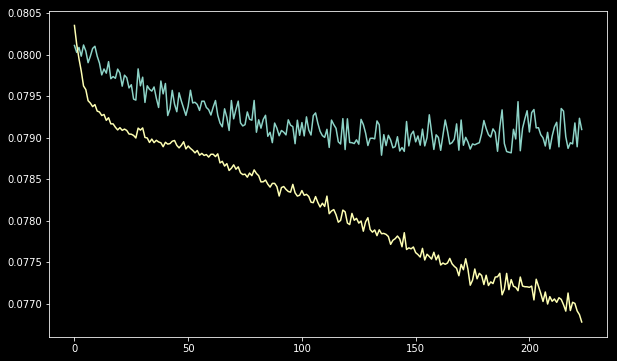

In [74]:
# 我們可以將結果給印出來，可以發現loss，也就是error，隨著訓練Epoch的次數不斷的
# 而val_loss則是優化到一個程度後，就沒辦法再優化了

import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

### lightgbm Model

In [75]:
# 這邊我們同時可以使用之前交過的lightgbm跟random forest來訓練額外的模型

import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Random Forest Model

In [76]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

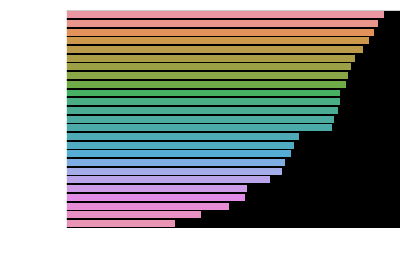

In [77]:
# 另外我們也可以畫出哪些feature是比較重要的，做一個比較，
# 大家可以根據feature重要程度，來新增或刪除features，可以調整到最好的效果

feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [78]:
# 剛剛訓練的資料，我們使用dataset_train，所以模型都是用這些資料進行訓練的
# 而我們也可以來看dataset_test，這個是機器學習模型沒有看過的資料
# 對於dataset_test，我們就可以來回測看看，是否機器學習模型已經學會了如何選股票的標的
# 我們可以用model.predict、cf.predict、cf2.predict將預測的結果給存起來
# 分別存放在dataset_test之中，所以可以看到dataset_test多了三個column分別是result、result2、result3
# 方便我們等會拿來回測時使用

vals = model.predict(dataset_test[feature_names].astype(float))
dataset_test['result'] = pd.Series(vals.swapaxes(0,1)[0], dataset_test.index)


vals = cf.predict(dataset_test[feature_names].astype(float))
dataset_test['result2'] = pd.Series(vals, dataset_test.index)

vals = cf2.predict(dataset_test[feature_names].astype(float))
dataset_test['result3'] = pd.Series(vals, dataset_test.index)

/Users/cheng-yuhan/miniconda3/envs/finlab/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/cheng-yuhan/miniconda3/envs/finlab/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/cheng-yuhan/miniconda3/envs/finlab/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

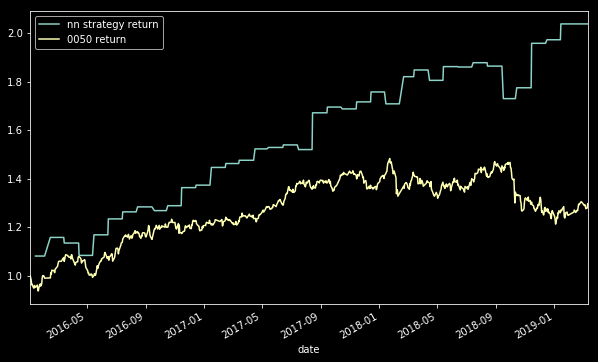

In [88]:
# 接下來我們就可以來進行回測了
# 首先我們將所有的日期給取出來，並且從小牌到大
# 下來我們創造一個return來存每個月的報酬率
# 然後就可以來進行報酬率的計算
# 對於每個月15號，我們將該時段的dataset_test給拿出來，也就是當月的股票清單
# 並且我們將「神經網路」、「lightgbm」和「random forest」的結果進行加總當作是rank，也就是總分
# 並且選出總分最大的30檔股票
# 並且將資產平均買入這30檔股票，所以平均報酬率將會是這30檔股票的平均
# 最後將算出來的平均報酬率放入returns中存起來

import math


dates = sorted(list(set(dataset_test.index)))


rs = []
for d in dates:
    dataset_time = dataset_test.loc[d]
    rank = dataset_time['result']+dataset_time['result2'] +dataset_time['result3'] 
    
    condition = (rank > rank.nlargest(30).iloc[-1]) 
    
    r = dataset_time['return'][condition].mean()
    
    if math.isnan(r):
        r = 1
        
    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

# 接下來我們將0050的結果與策略的結果作一個比較，首先，我們先將原本的returns報酬率轉換成series，
# 接下來我們將0050的數值拿出來，跟策略的報酬率一起繪製出來
# 最後我們可以加上每次換股票的摩擦成本，以易又是考慮手續費跟證交稅

rs = pd.Series(rs, index=dates).cumprod()

s0050 = close['0050']['2016':]

pd.DataFrame({'nn strategy return':rs.reindex(s.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()